In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [217]:
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip SST-2.zip

!mkdir MRPC
!wget https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt 
!mv msr_paraphrase_train.txt  ./MRPC/train.tsv
!wget https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt 
!mv msr_paraphrase_test.txt  ./MRPC/dev.tsv

mkdir: cannot create directory ‘MRPC’: File exists
--2021-03-21 14:24:40--  https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047044 (1023K) [text/plain]
Saving to: ‘msr_paraphrase_train.txt’

msr_paraphrase_trai 100%[===================>]   1023K  2.39MB/s    in 0.4s    

2021-03-21 14:24:41 (2.39 MB/s) - ‘msr_paraphrase_train.txt’ saved [1047044/1047044]

--2021-03-21 14:24:41--  https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from scipy import stats
from scipy.stats import norm
import random

import torchvision

import tqdm
from tqdm import trange

import pandas as pd
import csv


from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla P100-PCIE-16GB


In [4]:
def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            prediction = outputs[1].argmax(dim=-1, keepdim=True)
            correct += prediction.eq(labels.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

class Monitor:
    def __init__(self):
        if hasattr(tqdm.tqdm, '_instances'):
            [*map(tqdm.tqdm._decr_instances, list(tqdm.tqdm._instances))]

        self.learning_curve = []
        self.train_accuracy_curve = []
        self.val_accuracy_curve = []
        self.best_val_accuracy = 0
        self.best_val_epoch = 0

    def add_loss_value(self, value):
        self.learning_curve.append(value)

    def add_train_accuracy_value(self, value):
        self.train_accuracy_curve.append(value)

    def add_val_accuracy_value(self, value):
        self.val_accuracy_curve.append(value)

        if value > self.best_val_accuracy:
            self.best_val_accuracy = value
            self.best_val_epoch = len(self.val_accuracy_curve)

    def show(self):
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))
        axes[0].set_title('Loss')
        axes[0].plot(self.learning_curve)

        last_train_accuracy = self.train_accuracy_curve[-1]
        last_val_accuracy = self.val_accuracy_curve[-1]
        best_val_accuracy = self.best_val_accuracy
        best_val_accuracy = self.best_val_accuracy

        axes[1].set_title(f'Train {last_train_accuracy:.4f}, val {last_val_accuracy:.4f}, '
                          f'max val {self.best_val_accuracy:.4f} at {self.best_val_epoch}')
        axes[1].plot(self.train_accuracy_curve)
        axes[1].plot(self.val_accuracy_curve)

        plt.tight_layout()
        plt.show()


def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [221]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

In [222]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, GlueDataset
from transformers import GlueDataTrainingArguments as DataTrainingArguments
from transformers import (
    Trainer,
    TrainingArguments,
    glue_compute_metrics,
    glue_output_modes,
    glue_tasks_num_labels,
    set_seed,
)
from transformers import AlbertTokenizer, AlbertForSequenceClassification, BertForSequenceClassification, BertTokenizer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
task_name = 'SST-2'
#task_name = 'MRPC'

In [223]:
data_args = DataTrainingArguments(task_name=task_name, data_dir=f"./{task_name}")

train_dataset = GlueDataset(data_args, tokenizer=tokenizer)
eval_dataset = GlueDataset(data_args, tokenizer=tokenizer, mode="dev")

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/glue.py:91: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:331: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with t

In [6]:
def default_data_collator(features):
    """
    Very simple data collator that:
    - simply collates batches of dict-like objects
    - Performs special handling for potential keys named:
        - `label`: handles a single value (int or float) per object
        - `label_ids`: handles a list of values per object
    - does not do any additional preprocessing
    i.e., Property names of the input object will be used as corresponding inputs to the model.
    See glue and ner for example of how it's useful.
    """

    # In this function we'll make the assumption that all `features` in the batch
    # have the same attributes.
    # So we will look at the first element as a proxy for what attributes exist
    # on the whole batch.
    first = features[0]

    # Special handling for labels.
    # Ensure that tensor is created with the correct type
    # (it should be automatically the case, but let's make sure of it.)
    if hasattr(first, "label") and first.label is not None:
        if type(first.label) is int:
            labels = torch.tensor([f.label for f in features], dtype=torch.long)
        else:
            labels = torch.tensor([f.label for f in features], dtype=torch.float)
        batch = {"labels": labels}
    elif hasattr(first, "label_ids") and first.label_ids is not None:
        if type(first.label_ids[0]) is int:
            labels = torch.tensor([f.label_ids for f in features], dtype=torch.long)
        else:
            labels = torch.tensor([f.label_ids for f in features], dtype=torch.float)
        batch = {"labels": labels}
    else:
        batch = {}

    # Handling of all other possible attributes.
    # Again, we will use the first element to figure out which key/values are not None for this model.
    for k, v in vars(first).items():
        if k not in ("label", "label_ids") and v is not None and not isinstance(v, str):
            batch[k] = torch.tensor([getattr(f, k) for f in features], dtype=torch.long)
    return batch

## 2 Training procedure

In [225]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [226]:
# Method for gathering gradients from NN
# Only classifier layer
def get_grads(model):
    grads = []
    for param in model.classifier.parameters():
        if param.requires_grad == True:
            grads.append(param.grad.view(-1))
    grad_flat = torch.cat(grads)
    return grad_flat

In [7]:
def train_transformers(model, optimizer, loss_function, train_loader, val_loader, device, filepath, epochs=1, plot_each=1, log_iter=100):
    # send the model to that device
    model = model.to(device)
    monitor = Monitor()
    log_num_iter=0

    for epoch in trange(epochs):
        model.train()
        
        for i, batch in enumerate(train_loader):
            
            #Idea1 no batches full data-> bad runtime out of memory
            # send data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs[0]

            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            # do some visualization
            monitor.add_loss_value(loss.item())
            #calculate grad on iteration
            if (i+1) % log_iter == 0:
                log_num_iter+=1
                with open(f'{filepath}_logiter_{log_num_iter}.npy', 'ab') as file:
                    for batch_gr in train_loader:
                        input_ids_gr = batch_gr['input_ids'].to(device)
                        attention_mask_gr = batch_gr['attention_mask'].to(device)
                        labels_gr = batch_gr['labels'].to(device)

                        outputs_gr = model(input_ids_gr, attention_mask=attention_mask_gr, labels=labels_gr)

                        loss_gr = outputs_gr[0]
                        optimizer.zero_grad()
                        #calc the gradient on batch
                        # ? do we need retain_grads=False
                        loss_gr.backward()
                                #store the gradient
                                #Full gradient will be calculated later, 
                                #as mean of the saved gradients of all batches 
                        
                        grad = get_grads(model).cpu()
                        np.save(file, grad.numpy())
        # evaluate the model
        model.eval()
            
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        
        if epoch % plot_each == 0:
            monitor.show()

    return model, log_num_iter

## 3 Experiment


In [5]:
lr = 1e-2
epochs = 5
batch_size = 32
log_iter = 2

In [294]:
filepath = './grads/'

In [295]:
import os

if not os.path.exists(filepath):
    os.mkdir(filepath)

In [296]:
for file in os.listdir(filepath):
    os.remove(f'{filepath}{file}')

In [297]:
#subsample to make train faster again
n_train = int(len(train_dataset)*0.01)
train_data,_ = torch.utils.data.random_split(train_dataset, lengths=[n_train, len(train_dataset)-n_train], generator=torch.Generator().manual_seed(42))

n_eval = int(len(eval_dataset)*0.1)
eval_data,_ = torch.utils.data.random_split(eval_dataset, lengths=[n_eval, len(eval_dataset)-n_eval], generator=torch.Generator().manual_seed(42))

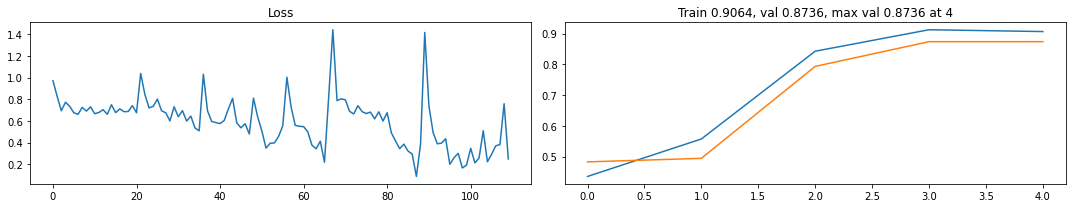

100%|██████████| 5/5 [08:13<00:00, 98.65s/it]


In [298]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=default_data_collator, num_workers=2)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=batch_size, collate_fn=default_data_collator, num_workers=2)

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

loss_function = torch.nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

mini_batch_model, total_iter = train_transformers(model, optimizer, loss_function,
                                      train_loader, eval_loader,
                                      device, filepath=filepath, epochs=epochs, log_iter=log_iter)

## 4 SG noise distribution's exploration

### 4.1 Calculating SGN

We decided to start our investigation from the elementwise localization of parameters in a particuar network and the exploration of its distribution throughout all minibatches for a fixed epoch.   

In [5]:
def alpha_estimator(x):

    K = len(x)
    list1 = np.array([d for d in range (1, K // 2 + 1) if K % d == 0] + [K])
    difference = abs(np.sqrt(K) - list1)
    K_1 = list1[np.argmin(difference)]
    K_2 = int(K/K_1)
    y = np.zeros(K_2)
    for i in range(K_2):
        y[i] = sum((x[j + (i-1) * K_1] for j in range(K_1)))

    return 1 / ((1/np.log(K_1)) * ((1/K_2) * sum(np.log(abs(y))) - (1/len(x)) * sum(np.log(abs(x)))))

def alpha_dynamics(mean_alphas, params):
    plt.figure(figsize=(12, 8))
    plt.plot(params, mean_alphas, 'o-', label=r'$ \alpha $')
    plt.xlabel('Iteration', size=13)
    plt.ylabel(r'mean $ \alpha $', size=13)
    plt.title(r'$ \alpha $ dynamics', size=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig(filepath + '_ep_50_alpha_dynamics.png')
    plt.show()

In [9]:
## This is quite slow block of code (takes about 10 minuets for 10 files with gradients from gDrive)
# amount of minibatches

alphas = []
sgn_storage = []
all_grads = []
for itera in range(1, total_iter, 1):
    batch_grads = []
    with open(f'{filepath}_logiter_{itera}.npy', 'rb') as file:
        while True:
            try:
                batch_grads.append(np.load(file))
            except:
                break
    
    grads = np.asarray(batch_grads)
    N = grads.shape[0]
    sgn = (grads - grads.sum(axis=0) / N).T
    del(batch_grads)
    # delete non-active neuron's sgn (zero-vectors sgn)
    sgn = sgn[~np.any(sgn == 0, axis=1), :]
    # store SGN for concrete epoch 
    sgn_storage.append(sgn)
    del(sgn)
    # calculating alpha for epoch
    alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn_storage[-1]))

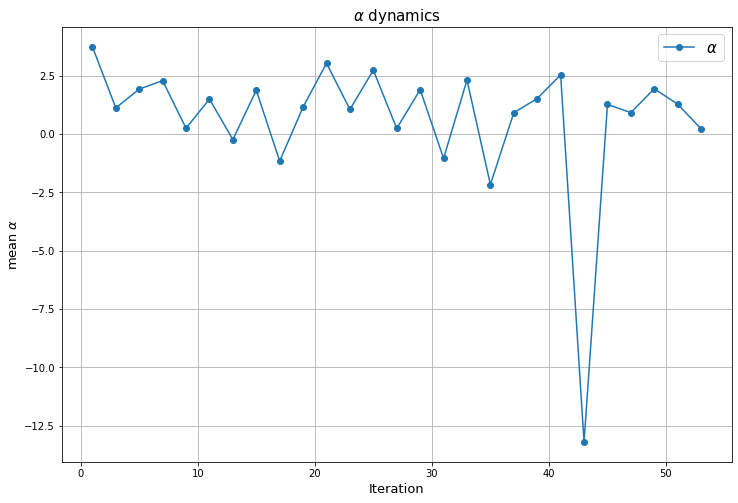

In [309]:
mean_alphas = []
for alpha_vec in alphas[::2]:
    mean_alphas.append(alpha_vec.mean())

alpha_dynamics(mean_alphas, [epoch for epoch in range(1, len(alphas)+1, 2)])

In [10]:
def SGD_noise_distplots(SGD_noise, distribution, dist_name, bins):

  params = distribution.fit(SGD_noise)
  Theoretical_dist = distribution(*params)
  x = np.linspace(SGD_noise.min(), SGD_noise.max(), len(SGD_noise))

  SGD_noise_hist = np.histogram(SGD_noise ,bins = bins)

  fig, axs = plt.subplots(4, 1, figsize=(16, 40))
  # axs[0].hist(SGD_noise, density=True, bins=bins, color='white', ec='black', label='SGD Noise')
  axs[0].hist(SGD_noise, density=True, bins=bins, label='SGD Noise')
  axs[0].hist(Theoretical_dist.rvs(size=len(SGD_noise)), density=True, bins=bins, label=dist_name)
  # axs[0].plot(x, Theoretical_dist.pdf(x), '--', color='black', label='Gaussian')
  axs[0].set_xlabel('SGD noise', size=13)
  axs[0].set_ylabel('Density', size=13)
  axs[0].set_title('SGD noise hist', size=15)
  axs[0].legend(fontsize=15)

  axs[1].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[1].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[1].set_xlabel('SGD noise', size=13)
  axs[1].set_ylabel('Density', size=13)
  axs[1].set_title('SGD noise dotted hist', size=15)
  axs[1].legend(fontsize=15)

  axs[2].set_yscale('log')
  axs[2].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[2].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[2].set_xlabel('SGD noise', size=13)
  axs[2].set_ylabel('log-scaled Density', size=13)
  axs[2].set_title('SGD noise dotted log hist', size=15)
  axs[2].legend(fontsize=15)

  stats.probplot(SGD_noise, dist=Theoretical_dist, plot=plt)
  plt.title('SGD noise QQ-plot', size=15)
  plt.xlabel('Theoretical Quantiles', size=13)
  plt.ylabel('Sample Quantiles', size=13)

  plt.grid()
  

  plt.show()  

In [11]:
len(sgn_storage)

54

In [12]:
sgn_storage[0].shape

(1538, 22)

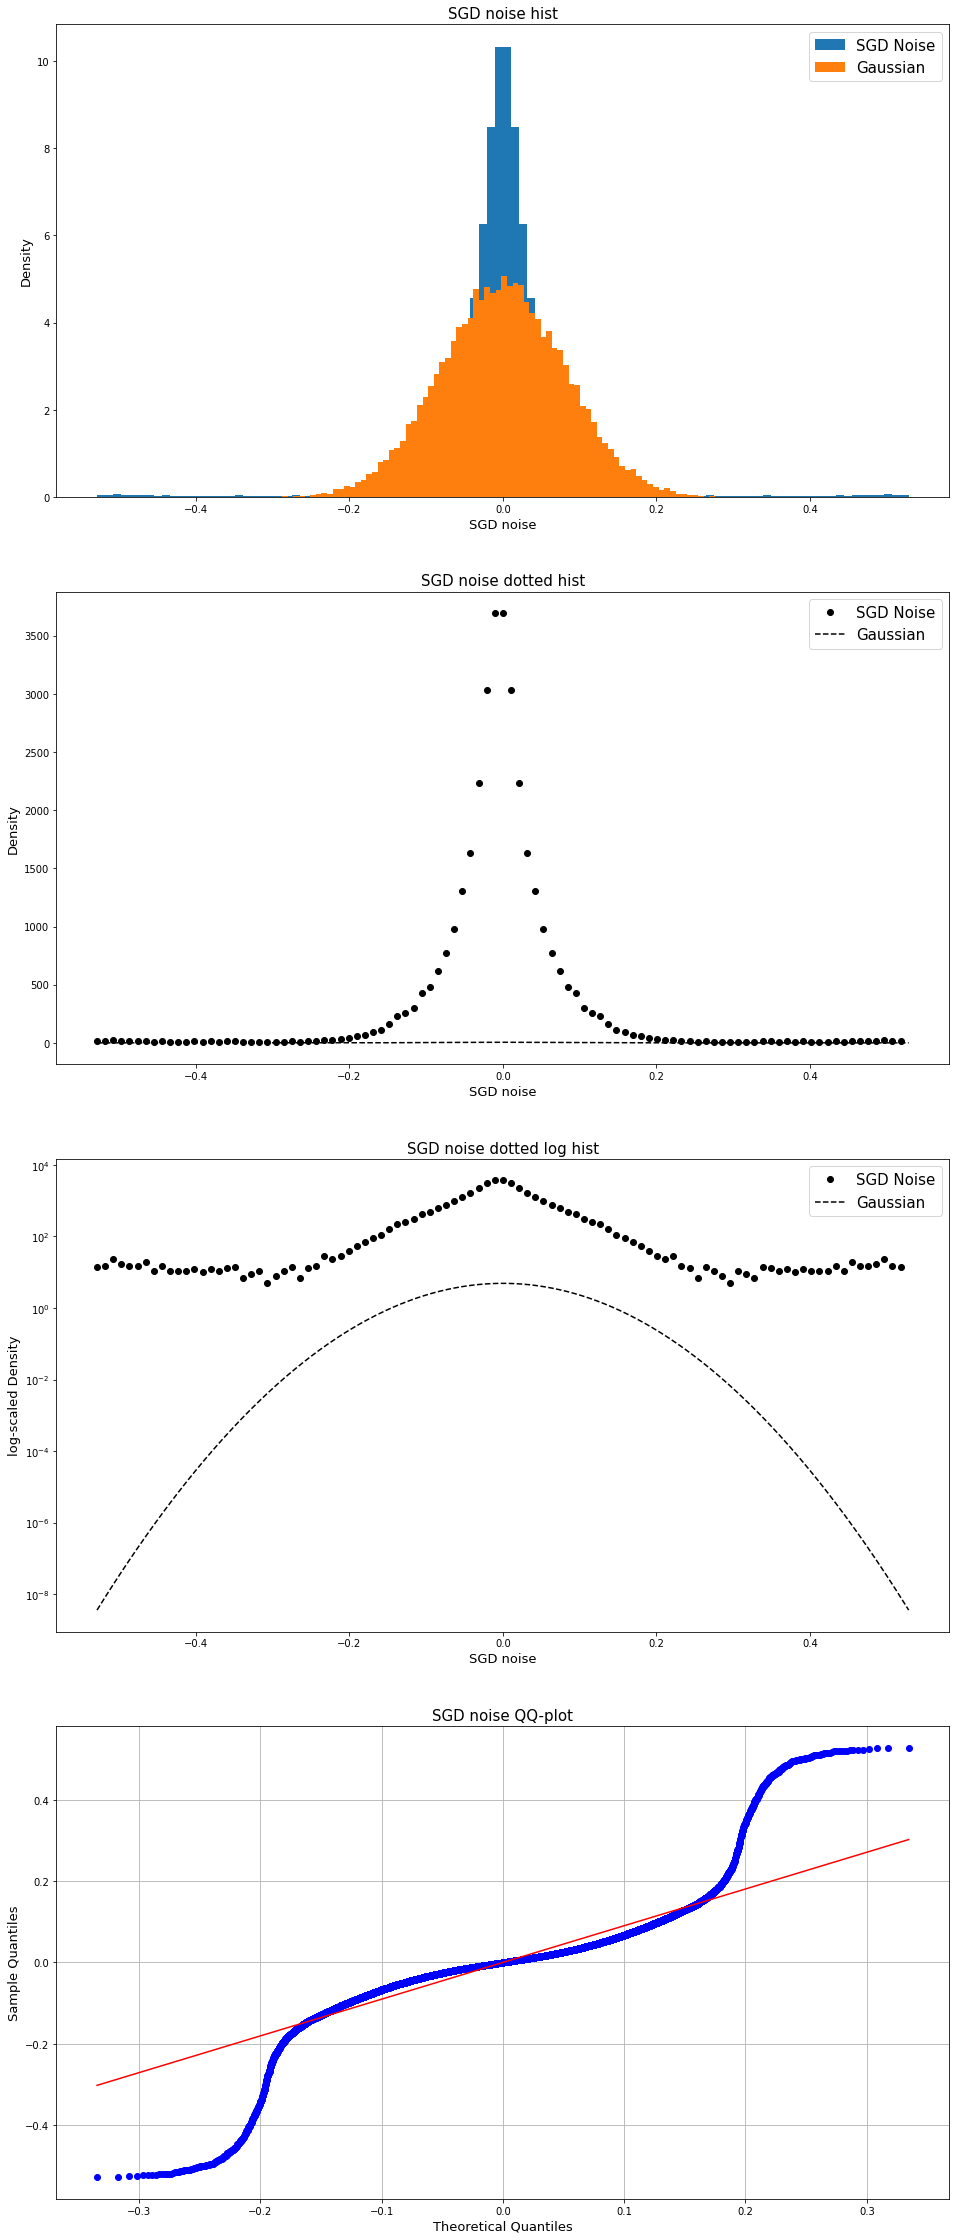

In [23]:
SGD_noise_distplots(SGD_noise=sgn_storage[0].flatten(), distribution=norm, dist_name='Gaussian', bins=100)

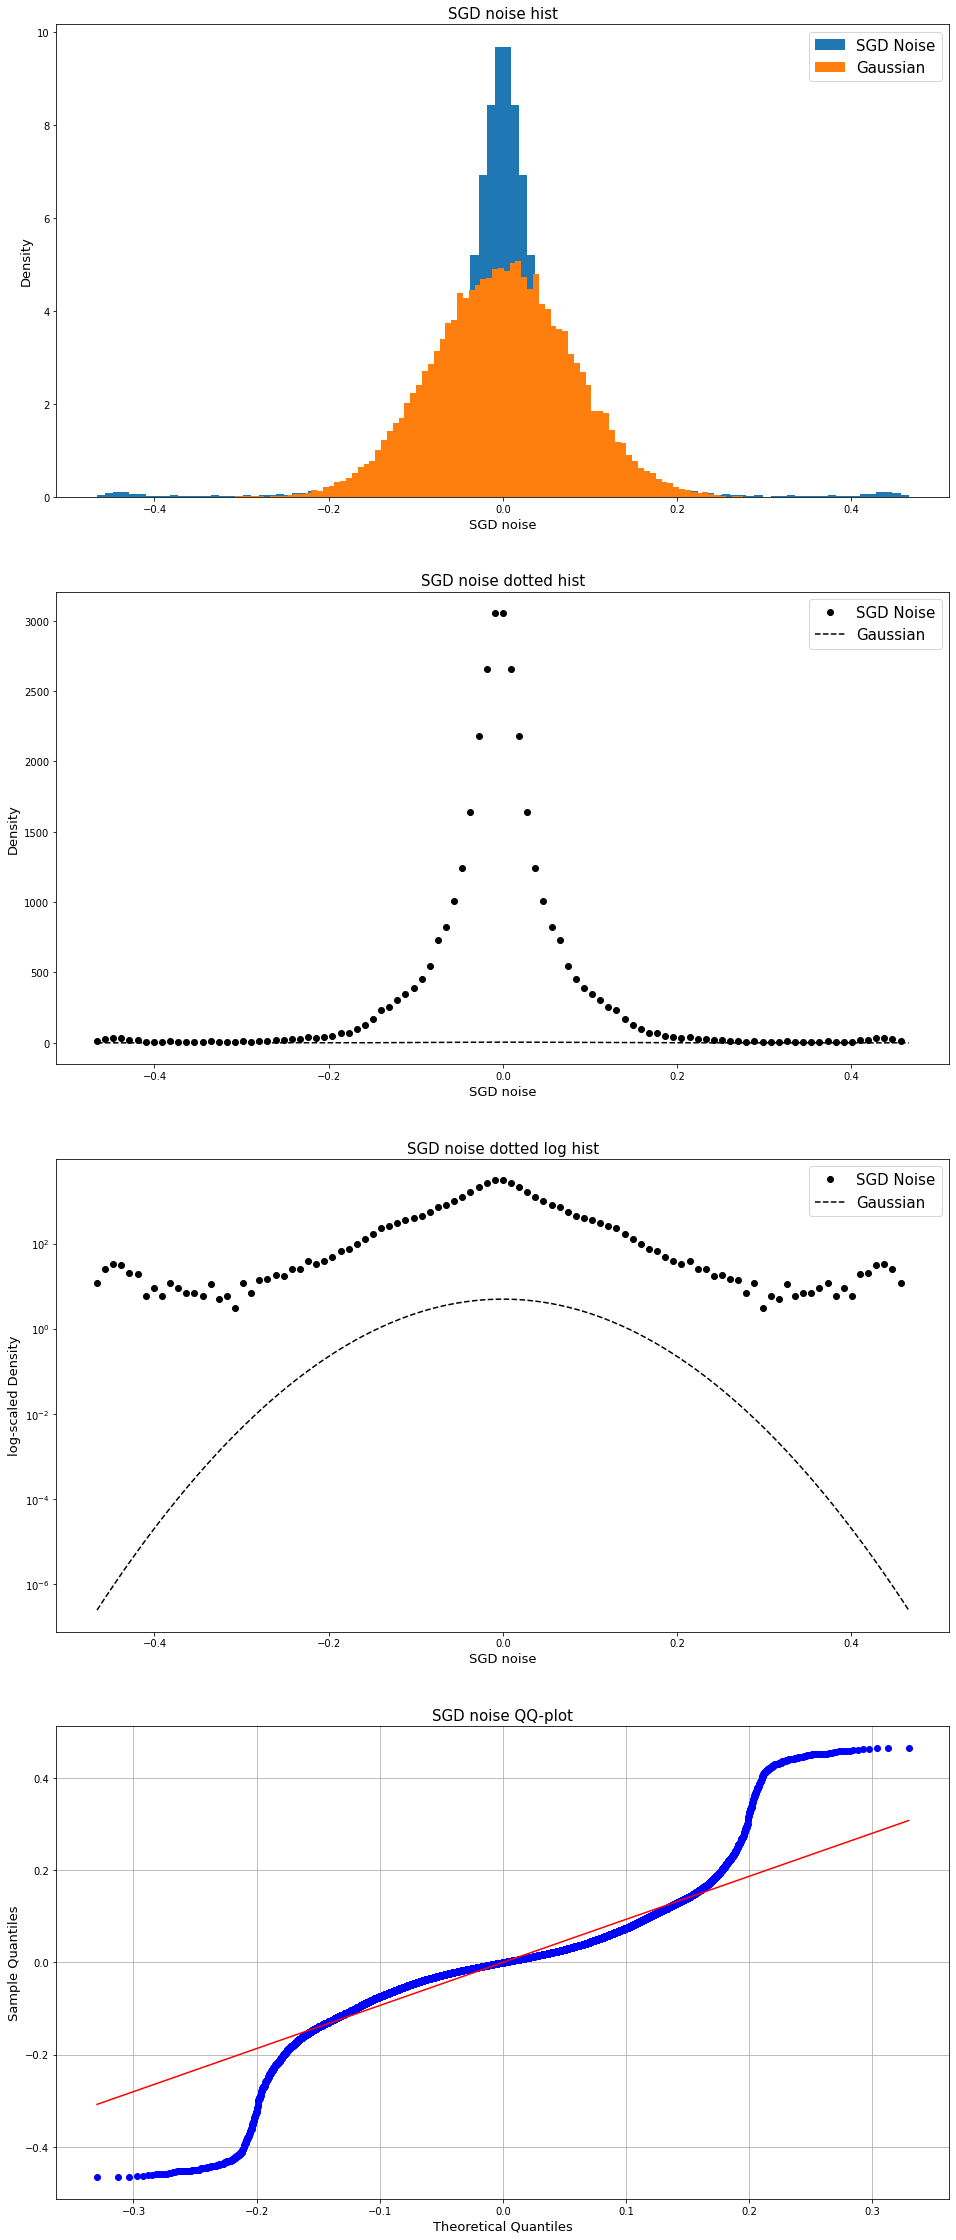

In [24]:
SGD_noise_distplots(SGD_noise=sgn_storage[-1].flatten(), distribution=norm, dist_name='Gaussian', bins=100)

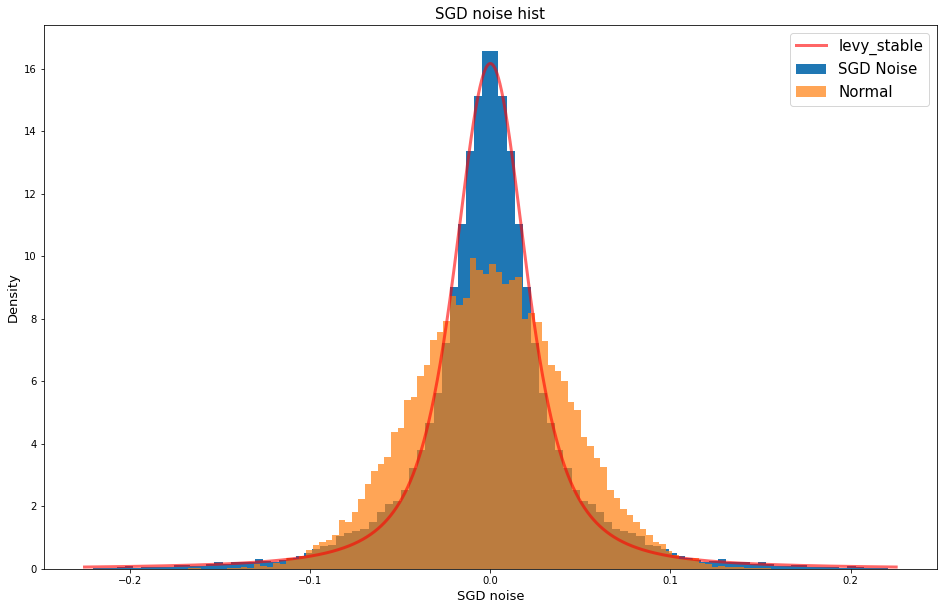

In [19]:
from scipy.stats import levy_stable
import numpy as np

bins = 100
SGD_noise = sgn_storage[-5].flatten()
pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
levy_params = pconv(*levy_stable._fitstart(SGD_noise))

x = np.linspace(SGD_noise.min(), SGD_noise.max(), len(SGD_noise))

SGD_noise_hist = np.histogram(SGD_noise ,bins = bins)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.hist(SGD_noise, density=True, bins=bins, label='SGD Noise')

params = norm.fit(SGD_noise)
Theoretical_dist = norm(*params)

ax.hist(Theoretical_dist.rvs(size=len(SGD_noise)), density=True, bins=bins, label='Normal', alpha=0.7)
ax.set_xlabel('SGD noise', size=13)
ax.set_ylabel('Density', size=13)
ax.set_title('SGD noise hist', size=15)
ax.plot(x, levy_stable.pdf(x, *levy_params),
       'r-', lw=3, alpha=0.6, label='levy_stable')
ax.legend(fontsize=15)

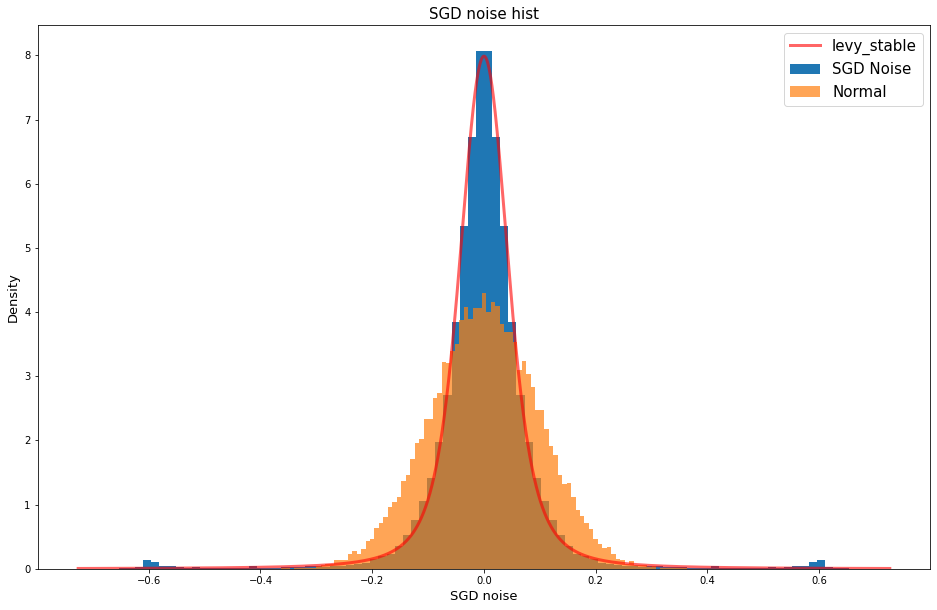

In [20]:
bins = 100
SGD_noise = sgn_storage[5].flatten()
pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
levy_params = pconv(*levy_stable._fitstart(SGD_noise))

x = np.linspace(SGD_noise.min(), SGD_noise.max(), len(SGD_noise))

SGD_noise_hist = np.histogram(SGD_noise ,bins = bins)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.hist(SGD_noise, density=True, bins=bins, label='SGD Noise')

params = norm.fit(SGD_noise)
Theoretical_dist = norm(*params)

ax.hist(Theoretical_dist.rvs(size=len(SGD_noise)), density=True, bins=bins, label='Normal', alpha=0.7)
ax.set_xlabel('SGD noise', size=13)
ax.set_ylabel('Density', size=13)
ax.set_title('SGD noise hist', size=15)
ax.plot(x, levy_stable.pdf(x, *levy_params),
       'r-', lw=3, alpha=0.6, label='levy_stable')
ax.legend(fontsize=15)